# Debugging and performances

In [2]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Load data

In [3]:
ds = pyxpcm.tutorial.open_dataset('argo').load()
# ds = pyxpcm.tutorial.open_dataset('isas_snapshot').load()
# ds = pyxpcm.tutorial.open_dataset('isas_series').load()
print(ds)
print('This dataset holds: %.1f MB' % (ds.nbytes / 1e6))

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source D

## Define/fit/predict a standard pyXpcm

In [4]:
from pyxpcm.pcmodel import pcm

In [5]:
# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z}
features_in_ds = {'temperature': 'TEMP'}

# features_pcm = {'temperature': z, 'salinity': z}
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

In [6]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Debugging

Use option ``debug`` to print log messages 

In [7]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.clean()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=1)

# Fit with log:
ds.pyxpcm.fit_predict(m, features=features_in_ds, inplace=True);

> Start preprocessing for action 'fit_predict'
	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	X RAVELED with success, now shape and type: <class 'xarray.core.dataarray.DataArray'> (7560, 282) <class 'dask.array.core.Array'>
	Output axis is in the input axis, not need to interpolate, simple intersection
	X INTERPOLATED with success, now shape and type: <class 'xarray.core.dataarray.DataArray'> (7560, 100) <class 'dask.array.core.Array'>
True
	X SCALED with success, now shape and type: <class 'xarray.core.dataarray.DataArray'> (7560, 100) <class 'numpy.ndarray'>
	X REDUCED with success, now shape and type: <class 'xarray.core.dataarray.DataArray'> (7560, 15) <class 'numpy.ndarray'>
	No need for homogenisation of temperature
> Preprocessing done, working with final X (<class 'xarray.core.dataarray.DataArray'>) array of shape: (7560, 15)  and sampling dimensions: ['N_PROF']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [8]:
# Create a PCM and use several methods to time:
m = pcm(K=8, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 27 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 177 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 1 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 328 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 135 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 22 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 3 ms
  fit.1-preprocess.2-feature_temperature.total: 670 ms
  fit.1-preprocess: 670 ms
  fit.1-preprocess.3-homogeniser: 3 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 704 ms
  fit.2-fit: 3244 ms
  fit.3-score: 7 ms
  fit: 3957 ms
  predict.1-preprocess.1-mask: 14 ms
  predict.1-preprocess.2-feature_temperature.1-ravel: 147 ms
  predict.1-preprocess.2-feature_temperature.2-interp: 1 ms
  predict.1-preprocess.2-feature_temperature.3-scale_fit: 0 ms
  predict.1-preprocess.2-feature_temperature.4-scale_transform: 174 ms
  predict.1-preprocess.2-feature_temperature.5-reduce_fit: 0 ms
  pre

In [9]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   27.925968
                           2-feature_temperature  1-ravel                177.482128
                                                  2-interp                 1.453161
                                                  3-scale_fit            328.825951
                                                  4-scale_transform      135.283947
                                                  5-reduce_fit            22.650003
                                                  6-reduce_transform       3.780127
                                                  total                  670.529127
                           total                                        1374.680996
                           3-homogeniser          total                    3.191948
                           4-xarray               total                    1.441956
       

### Compare details of steps for each method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-score,6-xarray,score
Method,,,,,,,,,
fit,2747.245312,3244.923115,NaN,7.922888,NaN,NaN,NaN,NaN,NaN
fit_predict,1224.279642,3565.838814,NaN,15.146017,NaN,5.898952,7.820129,335.227728,NaN
predict,1357.389927,NaN,11.896133,NaN,256.076097,NaN,NaN,NaN,8.413792


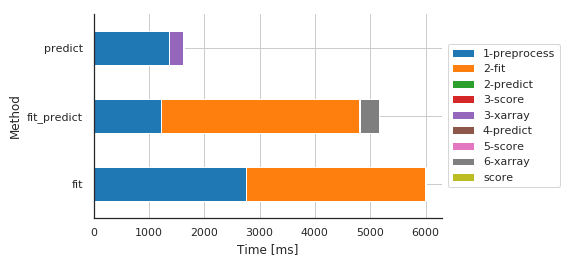

In [10]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method') # Default group/split
df

### Compare preprocessing steps for each method

Sub-sub-method,1-mask,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,
fit,27.925968,1340.004444,3.191948,1.441956
fit_predict,15.717745,592.421293,2.310991,1.136780
predict,14.646053,661.868811,0.002146,1.168728


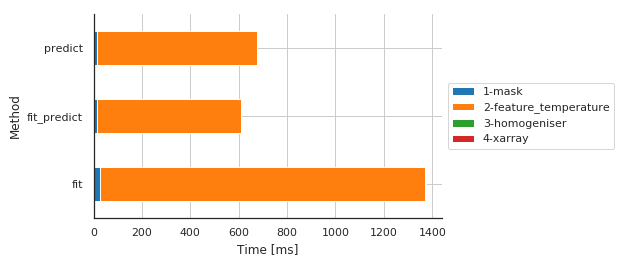

In [11]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,177.482128,1.453161,328.825951,135.283947,22.650003,3.780127
fit_predict,137.499094,1.342058,0.002146,153.117180,0.001907,3.997087
predict,147.835016,1.693010,0.000954,174.738884,0.001907,6.120920


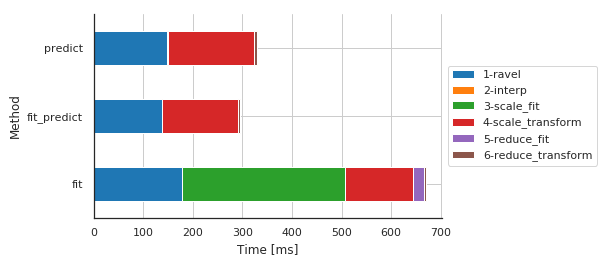

In [12]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_temperature,462.816238,4.48823,328.82905,463.140011,22.653818,13.898134


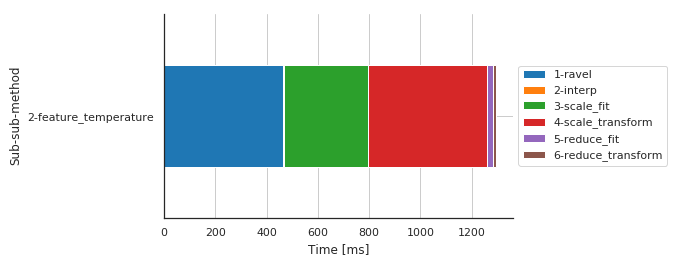

In [13]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method')
df